In [1]:
#必要ライブラリのインポート
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import cartopy, fiona, shapely, pyproj, rtree, pygeos
import cv2
matplotlib.rcParams['figure.dpi'] = 300 # 解像度
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rasterio as rio
import rasterio.mask
import folium
import zipfile
import glob
import shutil
# from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
# from PIL import Image
from IPython.display import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import MultiPolygon, Polygon
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask
from osgeo import gdal

import warnings
warnings.filterwarnings('ignore')

print("done")

done


In [2]:
# 行政区域データをダウンロードするフォルダの作成
os.makedirs('../outputs/ibrakiPolygon',exist_ok=True)

# wgetを行う
!wget --restrict-file-names=nocontrol \
     --content-disposition \
     --user-agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:52.0) Gecko/20100101 Firefox/52.0" \
     "https://nlftp.mlit.go.jp/ksj/gml/data/N03/N03-2019/N03-190101_08_GML.zip" \
     -P ../outputs/ibrakiPolygon

import zipfile

# ダウンロードしたファイルを展開する
with zipfile.ZipFile('../outputs/ibrakiPolygon/N03-190101_08_GML.zip') as zipf:
  for zinfo in zipf.infolist():        # ZipInfoオブジェクトを取得
      if not zinfo.flag_bits & 0x800:  # flag_bitsプロパティで文字コードを取得
          # 文字コードが(cp437)だった場合はcp932へ変換する
          # strオブジェクトのプロパティencode/decodeでcp932に変換
          # 変換後のファイル名をfilenameプロパティで再度し直す
          zinfo.filename = zinfo.filename.encode('cp437').decode('cp932')
          if os.sep != "/" and os.sep in zinfo.filename:
            zinfo.filename = zinfo.filename.replace(os.sep, "/")

      zipf.extract(zinfo, '../outputs/ibrakiPolygon')

--2024-06-26 06:04:10--  https://nlftp.mlit.go.jp/ksj/gml/data/N03/N03-2019/N03-190101_08_GML.zip
Resolving nlftp.mlit.go.jp (nlftp.mlit.go.jp)... 192.29.39.162, 192.29.39.48, 192.29.41.65, ...
Connecting to nlftp.mlit.go.jp (nlftp.mlit.go.jp)|192.29.39.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3716112 (3.5M) [application/zip]
Saving to: ‘../outputs/ibrakiPolygon/N03-190101_08_GML.zip.2’

N03-190101_08_GML.z 100%[===================>]   3.54M   987KB/s    in 42s     

2024-06-26 06:05:13 (85.7 KB/s) - ‘../outputs/ibrakiPolygon/N03-190101_08_GML.zip.2’ saved [3716112/3716112]



done


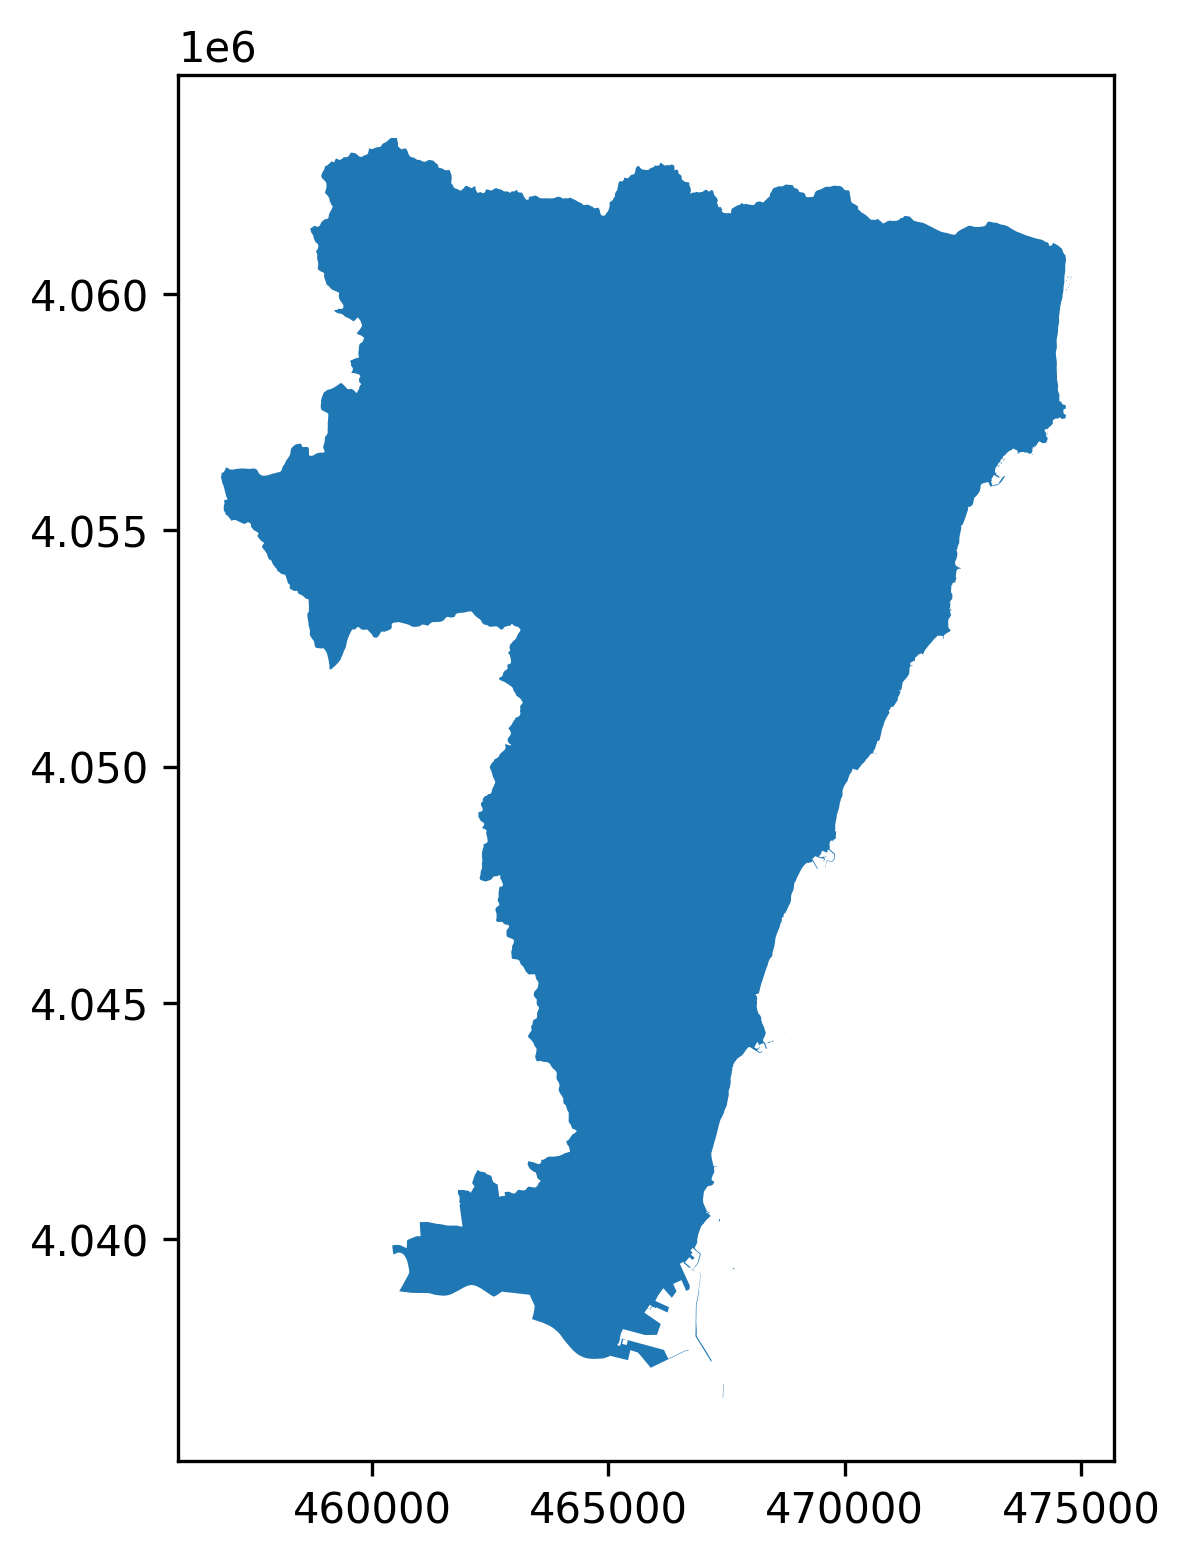

In [3]:
#ダウンロードしたデータを解凍して、ディレクトリを指定
shape_path = "../outputs/ibrakiPolygon/"

# 茨城県のshpの読み込み
in_shape = gpd.read_file(os.path.join(shape_path + "N03-19_08_190101.shp"),encoding="shift-jis")

# 日立市でソート
shape_srt = in_shape[in_shape["N03_004"].isin(["日立市"])]
shape_srt = shape_srt.drop(columns=["N03_002","N03_003"])

#画像に合わせて投影変換
out_file = os.path.join(shape_path + "re_N03-19_08_190101.shp")
re_shape = shape_srt.to_crs({"init": "epsg:32654"})

#出力
re_shape.to_file(driver="ESRI Shapefile",filename=out_file,encoding='utf-8')
print("done")

#GeoDataFrameを描画
f,ax = plt.subplots(1, figsize=(6,6))
ax = re_shape.plot(axes=ax)
plt.show();

In [4]:
# # ダウンロードしたデータがzipである場合には以下のコードを実行してください
# # 基本的にはSAFEファイルから利用されると思いますが、状況に応じて使ってください

# # ファイルの解凍（zipfileを使う場合）
# a = glob.glob('/content/drive/MyDrive/s2/*.zip') #s2というフォルダにダウンロードファイルが入っています。

# ziplis = []
# for f in a:
#   print(f[26:86])
#   ziplis.append(f[26:86])

# for file_title in ziplis:
#   print("start unzip:"+ file_title)
#   file_name = file_title +".zip"
#   file_dir = "/content/drive/MyDrive/s2/"
#   file_pass = os.path.join(file_dir + file_name)
#   print(file_pass)
#   with zipfile.ZipFile(file_pass) as zf:
#     zf.extractall()
#   print("done")

In [5]:
filePath = glob.glob("../data/Chapter4/s2/*.SAFE") #  指定したディレクトリ内にある.SAFEのパスを取得
print(os.listdir(filePath[0])) # フォルダの中身をチェック

['GRANULE']


In [6]:
# バンドの数を調べます
print('The number of bands',+len(os.listdir('../data/Chapter4/s2/S2A_MSIL1C_20170508T012701_N0205_R074_T54SVF_20170508T013110.SAFE/GRANULE/L1C_T54SVF_A009795_20170508T013110/IMG_DATA')))

The number of bands 3


In [7]:
# ファイル内のデータを探索するために、.SAFE以前の文字列を取得
ziplist = []

for f in filePath:
  print(f[26:86])
  ziplist.append(f[26:86])

IL1C_20170508T012701_N0205_R074_T54SVF_20170508T013110.SAFE


In [8]:
#作業用ディレクトリ（フォルダ）の作成
os.makedirs('work', exist_ok=True)

path = '../outputs/'
work_path = '../outputs/work'

RGB_dir = '../outputs/work/RGB_TIF'
os.makedirs(RGB_dir, exist_ok=True)

NDVI_dir = '../outputs/work/NDVI'
os.makedirs(NDVI_dir, exist_ok=True)

NDVI_mask_dir = '../outputs/work/NDVI_mask'
os.makedirs(NDVI_mask_dir, exist_ok=True)

In [10]:
# RGB画像を作成します。やや時間がかかります
parentPath = "../data/Chapter4/s2/"
for file_title in ziplist:
  print("Start make RGB TIF image " +'<'+ file_title +'>')

  # jp2データの探索
  path_A = parentPath + str(file_title)
  f1 = os.listdir(path_A)
  path_B = parentPath + str(file_title) + '.SAFE/GRANULE/' + str(f1[0])
  f2 = os.listdir(path_B)
  path_C = parentPath + str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) + '/IMG_DATA/'
  f3 = os.listdir(path_C)

  b2 = rio.open(parentPath + str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B02.jp2'))
  b3 = rio.open(parentPath + str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B03.jp2'))
  b4 = rio.open(parentPath +  str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B04.jp2'))
  # 出力ファイル名
  RGB_path = os.path.join(RGB_dir,'sentinel-2_'+str(f3[0][7:15])+'_RGB.tif')
  
  # GeoTIFFの作成
  RGB_colar = rio.open(RGB_path,'w',driver='Gtiff', #driverにGtiff(GeoTIFF)
                       width=b4.width, height=b4.height, #画像の高さや幅を指定。B04のバンドと同じ大きさにしています
                       count=3, #3つのバンドを利用 (B02, B03, B04)
                       crs=b4.crs, #crsもB04と同様。epsg:32654
                       transform=b4.transform, #データに対する変換も同様のもの
                       dtype=rio.uint16 #データ型を指定
                       )
  # 各々のバンド情報をRGB_colorに書き込み
  RGB_colar.write(b2.read(1),3) #青
  RGB_colar.write(b3.read(1),2) #緑
  RGB_colar.write(b4.read(1),1) #赤
  RGB_colar.close()

  print("---masking---")

  # 画像の切り取り処理
  with fiona.open(out_file, "r") as mask:
    masks = [feature["geometry"] for feature in mask] #ベクターデータが持つ図形情報の取得

  with rio.open(RGB_path) as src:
    out_image, out_transform = rio.mask.mask(src, masks, crop=True) #mask処理の実行
    out_meta = src.meta #作成する画像の情報はもともとの画像と同様のものにします

  # メタ情報の更新
  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

  # 画像の書き出し
  with rio.open(RGB_path, "w", **out_meta) as dest:
    dest.write(out_image)
  
  # 画像表示のため8bit形式で書き出しを行います
  # scaleを調整することにより画像の見栄えが変化します
  scale = '-scale 0 255 0 15' # 元ファイルのピクセル値のmin, maxから変換後のピクセル値 min, maxとなります
  options_list = ['-ot Byte','-of Gtiff',scale]
  options_string = " ".join(options_list)

  gdal.Translate(os.path.join(RGB_dir + "/" + 'sentinel-2_'+str(f3[0][7:15])+'.tif'),os.path.join(RGB_dir + "/" + 'sentinel-2_'+str(f3[0][7:15])+'_RGB.tif'),options = options_string)

  print("Done")


Start make RGB TIF image <IL1C_20170508T012701_N0205_R074_T54SVF_20170508T013110.SAFE>


FileNotFoundError: [Errno 2] No such file or directory: '../data/Chapter4/s2/IL1C_20170508T012701_N0205_R074_T54SVF_20170508T013110.SAFE'